# GMM

In [1]:
from pathlib import Path
import os

os.chdir(Path(os.getcwd()).parent)

In [2]:
from AnomalyCableDetection.load import Loader, Preprocessor
from AnomalyCableDetection.stl import CableSTL, CrossCorrelation, AdjacencyType
from AnomalyCableDetection.gmm import *
from AnomalyCableDetection.plot import *

In [3]:
from sklearn import mixture
from os.path import join
from pathlib import Path

import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os
import re

In [4]:
cable_number = 10

### Load pre1 dataset

In [5]:
gmm = CableGMM()
cable_dict = gmm.cable_dict
date_list = gmm.date_list
scatter_dict = gmm.scatter_dict
cable_name = f'SJ{str(cable_number).zfill(2)}'

### Load best number of clusters

In [6]:
bic_path = join(Path(os.getcwd()), 'results', 'gmm', 'bic')
mean_path = join(bic_path, 'mean.csv')
mean_df = pd.read_csv(mean_path, index_col=0)
mean_list = mean_df.loc[cable_name, :].to_list()
n_clusters = mean_list.index(min(mean_list)) + 1

### Get GMM model results

In [7]:
gmm_dict = dict()
x_min = 10000
x_max = -0.00001

for date in date_list:
    gmm_df = gmm.get_gmm_model_with_n_clusters(date, cable_number, 2)
    x_list = gmm_df.loc[:, 'x'].to_list()
    if min(x_list) < x_min:
        x_min = min(x_list)
    if max(x_list) > x_max:
        x_max = max(x_list)
    gmm_dict.update({date: gmm_df})

### Contour Visualize

In [8]:
def map_x_axis(old_axis, new_axis):
    new_min = min(new_axis)
    new_max = max(new_axis)
    new_len = len(new_axis)
    one_step = (new_max - new_min) / new_len
    
    index_list = []
    for old_value in old_axis:
        index = int((old_value - new_min) / one_step)
        index_list.append(index)
    
    return index_list

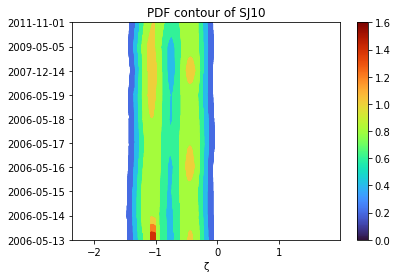

In [9]:
xp = np.linspace(x_min-0.01, x_max+0.01, 10000)
yp = date_list
zp = np.empty((len(yp), len(xp)))

for i, date in enumerate(date_list):
    gmm_df = gmm_dict[date]
    x_list = gmm_df.loc[:, 'x'].to_list()
    x_index_list = map_x_axis(x_list, xp)
    
    y_list = gmm_df.loc[:, 'y'].to_list()
    
    for j, x_index in enumerate(x_index_list):
        zp[i][x_index] = y_list[j]
        
contours = plt.contour(xp, yp, zp, cmap='turbo')
norm = mcolors.Normalize(vmin=contours.cvalues.min(), vmax=contours.cvalues.max())

sm = plt.cm.ScalarMappable(norm=norm, cmap=contours.cmap)
sm.set_array([])

plt.colorbar(sm, ticks=contours.levels)
plt.title(f'PDF contour of {cable_name}')
plt.xlabel(u'\u03B6')
plt.show()